# 支持向量机模型

i is 0,Ei is 1.0
valiEcacheList is [0]
第二个因子的坐标3
a2 归约之前是[[1.14800852]]
a2 归约之后is [[0.8]]
a1更新之后是[[0.8]]
b is [[7.34295816]]
fullSet, iter:0 i: 0 pairs changed 1
i is 1,Ei is [[-4.75767307]]
fullSet, iter:0 i: 1 pairs changed 1
i is 2,Ei is [[2.02536013]]
fullSet, iter:0 i: 2 pairs changed 1
i is 3,Ei is [[-0.30314106]]
fullSet, iter:0 i: 3 pairs changed 1
i is 4,Ei is [[-2.27615271]]
fullSet, iter:0 i: 4 pairs changed 1
i is 5,Ei is [[-0.49544545]]
valiEcacheList is [0 3 5]
第二个因子的坐标0
L=H
fullSet, iter:0 i: 5 pairs changed 1
i is 6,Ei is [[-3.32914811]]
fullSet, iter:0 i: 6 pairs changed 1
i is 7,Ei is [[1.55500495]]
fullSet, iter:0 i: 7 pairs changed 1
i is 8,Ei is [[1.97930322]]
fullSet, iter:0 i: 8 pairs changed 1
i is 9,Ei is [[4.62064686]]
fullSet, iter:0 i: 9 pairs changed 1
i is 10,Ei is [[-0.5364507]]
fullSet, iter:0 i: 10 pairs changed 1
i is 11,Ei is [[-3.68990084]]
fullSet, iter:0 i: 11 pairs changed 1
i is 12,Ei is [[-3.53224399]]
fullSet, iter:0 i: 12 pairs changed 1
i is 

D:\anaconda3\envs\swin\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
D:\anaconda3\envs\swin\lib\site-packages\ipykernel_launcher.py:93: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.


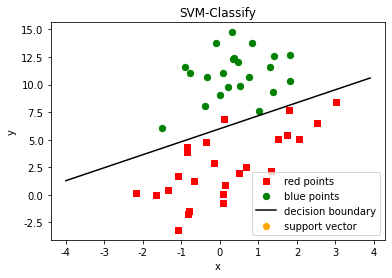

In [3]:
from numpy import *
import random
import matplotlib.pyplot as plt
import numpy
import matplotlib.font_manager as font_manager
 
def kernelTrans(X,A,kTup):                    # 核函数(此例未使用)
    m,n=shape(X)
    K = mat(zeros((m,1)))
    if kTup[0] =='lin':
        K=X*A.T
    elif kTup[0]=='rbf':
        for j in range(m):
            deltaRow = X[j,:]-A
            K[j]=deltaRow*deltaRow.T           # ||w||^2 = w^T * w
        K =exp(K/(-1*kTup[1]**2))              # K = e^(||x-y||^2 / (-2*sigma^2))
    else:
        raise NameError("Houston we Have a problem --")
    return K
 
class optStruct:
    def __init__(self,dataMain,classLabel,C,toler,kTup):
 
        self.X = dataMain                     # 样本矩阵
        self.labelMat = classLabel
        self.C = C                            # 惩罚因子
        self.tol = toler                      # 容错率
        self.m = shape(dataMain)[0]           # 样本点个数
        self.alphas = mat(zeros((self.m,1)))  # 产生m个拉格郎日乘子，组成一个m×1的矩阵
        self.b =0                             # 决策面的截距
        self.eCache = mat(zeros((self.m,2)))    # 产生m个误差 E=f(x)-y ,设置成m×2的矩阵，矩阵第一列是标志位，标志为1就是E计算好了，第二列是误差E
        # self.K = mat(zeros((self.m,self.m)))
        # for i in range(self.m):               # K[,]保存的是任意样本之间的相似度(用高斯核函数表示的相似度)
        #     self.K[:,i]=kernelTrans(self.X,self.X[i,:],kTup)

def loadDataSet(filename):                 # 加载数据
    dataMat = []
    labelMat = []
    fr = open(filename)
    for line in fr.readlines():
        lineArr = line.split()
        dataMat.append([float(lineArr[0]),float(lineArr[1])])
        labelMat.append(float(lineArr[2]))     # 一维列表
    return dataMat, labelMat
 
def selectJrand(i, m):       # 随机选择一个不等于i的下标
    j =i
    while(j==i):
        j = int(random.uniform(0,m))
    return j
 
def clipAlpha(aj, H,L):
    if aj>H:                      # 如果a^new 大于上限值，那么就把上限赋给它
        aj = H
    if L>aj:                      # 如果a^new 小于下限值，那么就把下限赋给它
        aj = L
    return aj
 
def calcEk(oS, k):           # 计算误差E, k代表第k个样本点，它是下标，oS是optStruct类的实例
    # fXk = float(multiply(oS.alphas,oS.labelMat).T * oS.K[:,k] + oS.b)   # 公式f(x)=sum(ai*yi*xi^T*x)+b
    fXk = float(multiply(oS.alphas,oS.labelMat).T * (oS.X*oS.X[k,:].T)) +oS.b
    Ek = fXk - float(oS.labelMat[k])          # 计算误差 E=f(x)-y
    return Ek
 
def selectJ(i, oS, Ei):      # 选择两个拉格郎日乘子,在所有样本点的误差计算完毕之后，寻找误差变化最大的那个样本点及其误差
    maxK = -1                # 最大步长的因子的下标
    maxDeltaE = 0            # 最大步长
    Ej = 0                   # 最大步长的因子的误差
    oS.eCache[i] = [1,Ei]
    valiEcacheList = nonzero(oS.eCache[:,0].A)[0]    # nonzero结果是两个array数组，第一个数组是不为0的元素的x坐标，第二个数组是该位置的y坐标
                                                  # 此处寻找误差矩阵第一列不为0的数的下标
    print("valiEcacheList is {}".format(valiEcacheList))
    if (len(valiEcacheList))>1:
        for k in valiEcacheList:          # 遍历所有计算好的Ei的下标，valiEcacheLIst保存了所有样本点的E，计算好的有效位置是1,没计算好的是0
 
            if k == i:
                continue
            Ek = calcEk(oS,k)
            deltaE = abs(Ei-Ek)          # 距离第一个拉格朗日乘子a1绝对值最远的作为第二个朗格朗日乘子a2
            if deltaE>maxDeltaE:
                maxK = k                 # 记录选中的这个乘子a2的下标
                maxDeltaE = deltaE       # 记录他俩的绝对值
                Ej = Ek                  # 记录a2此时的误差
        return maxK, Ej
    else:                             # 如果是第一次循环，随机选择一个alphas
        j = selectJrand(i, oS.m)
        # j = 72
        Ej = calcEk(oS, j)
    return j,Ej
 
def updateEk(oS, k):
    Ek = calcEk(oS, k)
    oS.eCache[k] = [1,Ek]        # 把第k个样本点的误差计算出来，并存入误差矩阵，有效位置设为1

def innerL(i, oS):
    Ei = calcEk(oS, i)           # KKT条件， 若yi*(w^T * x +b)-1<0 则 ai=C  若yi*(w^T * x +b)-1>0 则 ai=0
    print("i is {0},Ei is {1}".format(i,Ei))
    if ((oS.labelMat[i]*Ei < -oS.tol) and (oS.alphas[i] < oS.C)) or ((oS.labelMat[i]*Ei > oS.tol) and (oS.alphas[i] > 0)):
        j,Ej = selectJ(i,oS,Ei)
        print("第二个因子的坐标{}".format(j))
        alphaIold = oS.alphas[i].copy()       # 用了浅拷贝， alphaIold 就是old a1,对应公式
        alphaJold = oS.alphas[j].copy()
        if oS.labelMat[i] != oS.labelMat[j]:  # 也是根据公式来的，y1 不等于 y2时
            L = max(0,oS.alphas[j] - oS.alphas[i])
            H = min(oS.C, oS.C+oS.alphas[j]-oS.alphas[i])
        else:
            L = max(0,oS.alphas[j]+oS.alphas[i]-oS.C)
            H = min(oS.C,oS.alphas[j]+oS.alphas[i])
        if L==H:         # 如果这个j让L=H,i和j这两个样本是同一类别，且ai=aj=0或ai=aj=C，或者不同类别，aj=C且ai=0
                         # 当同类别时 ai+aj = 常数 ai是不满足KKT的，假设ai=0,需增大它，那么就得减少aj，aj已经是0了，不能最小了，所以此情况不允许发生
                         # 当不同类别时 ai-aj=常数，ai是不满足KKT的，ai=0,aj=C,ai需增大，它则aj也会变大，但是aj已经是C的不能再大了，故此情况不允许
            print("L=H")
            return 0
        # eta = 2.0*oS.K[i,j]-oS.K[i,i]-oS.K[j,j]   # eta=K11+K22-2*K12
        eta = 2.0*oS.X[i,:]*oS.X[j,:].T - oS.X[i,:]*oS.X[i,:].T - oS.X[j,:]*oS.X[j,:].T
        if eta >= 0:                 # 这里跟公式正好差了一个负号，所以对应公式里的 K11+K22-2*K12 <=0，即开口向下，或为0成一条直线的情况不考虑
            print("eta>=0")
            return 0
        oS.alphas[j]-=oS.labelMat[j]*(Ei-Ej)/eta     # a2^new = a2^old+y2(E1-E2)/eta
        print("a2 归约之前是{}".format(oS.alphas[j]))
        oS.alphas[j]=clipAlpha(oS.alphas[j],H,L)     # 根据公式，看看得到的a2^new是否在上下限之内
        print("a2 归约之后is {}".format(oS.alphas[j]))
        # updateEk(oS,j)               # 把更新后的a2^new的E更新一下
        if abs(oS.alphas[j]-alphaJold)<0.00001:
            print("j not moving enough")
            return 0
        oS.alphas[i] +=oS.labelMat[j]*oS.labelMat[i]*(alphaJold-oS.alphas[j])   # 根据公式a1^new = a1^old+y1*y2*(a2^old-a2^new)
        print("a1更新之后是{}".format(oS.alphas[i]))
        # updateEk(oS,i)
        # b1^new = b1^old+(a1^old-a1^new)y1*K11+(a2^old-a2^new)y2*K12-E1
        # b1 = oS.b-Ei-oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.K[i,i]-oS.labelMat[j]*\
        #      (oS.alphas[j]-alphaJold)*oS.K[i,j]
 
        b1 = oS.b-Ei-oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.X[i,:]*oS.X[i,:].T-oS.labelMat[j]* \
             (oS.alphas[j]-alphaJold)*oS.X[i,:]*oS.X[j,:].T
        # b2 = oS.b-Ej-oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.K[i,j]-oS.labelMat[j]* \
        #      (oS.alphas[j]-alphaJold)*oS.K[j,j]
 
        b2 = oS.b-Ej-oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.X[i,:]*oS.X[j,:].T-oS.labelMat[j]* \
             (oS.alphas[j]-alphaJold)*oS.X[j,:]*oS.X[j,:].T
        updateEk(oS,j)          # 个人认为更新误差应在更新b之后，因为公式算出的b的公式使用的是以前的Ei
        updateEk(oS,i)
        # b2^new=b2^old+(a1^old-a1^new)y1*K12+(a2^old-a2^new)y2*K22-E2
        if (0 < oS.alphas[i]) and (oS.C > oS.alphas[i]):
            oS.b = b1.A[0][0]
        elif (0<oS.alphas[j]) and (oS.C > oS.alphas[j]):
            oS.b = b2.A[0][0]
        else:
            oS.b = (b1+b2)/2.0
 
 
        print("b is {}".format(oS.b))
        return 1
    else:
        return 0

def smoP(dataMatIn, classLabels, C,toler,maxIter,kTup=('lin',)):
    oS = optStruct(mat(dataMatIn), mat(classLabels).transpose(),C,toler,kTup)
    iter = 0
    entireSet = True              # 两种遍历方式交替
    alphaPairsChanged = 0
    while (iter<maxIter) and ((alphaPairsChanged>0) or (entireSet)):
        alphaPairsChanged = 0
        if entireSet:
            for i in range(oS.m):
                alphaPairsChanged += innerL(i,oS)
                print("fullSet, iter:%d i: %d pairs changed %d"%(iter,i ,alphaPairsChanged))
 
            iter+=1
            print("第一种遍历alphaRairChanged is {}".format(alphaPairsChanged))
            print("-----------eCache is {}".format(oS.eCache))
            print("***********alphas is {}".format(oS.alphas))
            print("---------------------------------------")
        else:
            nonBoundIs = nonzero((oS.alphas.A > 0) * (oS.alphas.A < C))[0]  # 这时数组相乘，里面其实是True 和False的数组，得出来的是
                                                                          # 大于0并且小于C的alpha的下标
            for i in nonBoundIs:
                alphaPairsChanged += innerL(i,oS)
                print("non-bound, iter: %d i:%d, pairs changed %d"%(iter,i,alphaPairsChanged))
            print("第二种遍历alphaPairChanged is {}".format(alphaPairsChanged))
            iter+=1
        if entireSet:
            entireSet = False  # 当第二种遍历方式alpha不再变化，那么继续第一种方式扫描，第一种方式不再变化，此时alphachanged为0且entireSet为false，退出循环
        elif (alphaPairsChanged==0):
            entireSet=True
        print("iteration number: %d"%iter)
    return oS.b,oS.alphas
 
def calcWs(alphas,dataArr,classLabels):                # 通过alpha来计算w
    X = mat(dataArr)
    labelMat = mat(classLabels).transpose()
    m,n = shape(X)
    w = zeros((n,1))
    for i in range(m):
        w += multiply(alphas[i]*labelMat[i], X[i,:].T)        # w = sum(ai*yi*xi)
    return w
 
def draw_points(dataArr,classlabel, w,b,alphas):
    myfont = font_manager.FontProperties(fname='./font/simhei.ttf')    # 显示中文
    plt.rcParams['axes.unicode_minus'] = False     # 防止坐标轴的‘-’变为方块
    m = len(classlabel)
    red_points_x=[]
    red_points_y =[]
    blue_points_x=[]
    blue_points_y =[]
    svc_points_x =[]
    svc_points_y =[]
    # print(type(alphas))
    svc_point_index = nonzero((alphas.A>0) * (alphas.A <0.8))[0]
    svc_points = array(dataArr)[svc_point_index]
    svc_points_x = [x[0] for x in list(svc_points)]
    svc_points_y = [x[1] for x in list(svc_points)]
    print("svc_points_x",svc_points_x)
    print("svc_points_y",svc_points_y)
 
    for i in range(m):
        if classlabel[i] ==1:
            red_points_x.append(dataArr[i][0])
            red_points_y.append(dataArr[i][1])
        else:
            blue_points_x.append(dataArr[i][0])
            blue_points_y.append(dataArr[i][1])
 
    fig = plt.figure()                     # 创建画布
    ax = fig.add_subplot(111)
    ax.set_title("SVM-Classify")           # 设置图片标题
    ax.set_xlabel("x")                     # 设置坐标名称
    ax.set_ylabel("y")
    ax1=ax.scatter(red_points_x, red_points_y, s=30,c='red', marker='s')   #s是shape大小，c是颜色，marker是形状，'s'代表是正方形,默认'o'是圆圈
    ax2=ax.scatter(blue_points_x, blue_points_y, s=40,c='green')
    # ax.set_ylim([-6,5])
    print("b",b)
    print("w",w)
    x = arange(-4.0, 4.0, 0.1)                   # 分界线x范围,步长为0.1
    # x = arange(-2.0,10.0)
    if isinstance(b,numpy.matrixlib.defmatrix.matrix):
        b = b.A[0][0]
    y = (-b-w[0][0]*x)/w[1][0]    # 直线方程 Ax + By + C = 0
    ax3,=plt.plot(x,y, 'k')
    ax4=plt.scatter(svc_points_x,svc_points_y,s=50,c='orange',marker='p')
    plt.legend([ax1, ax2,ax3,ax4], ["red points","blue points", "decision boundary","support vector"], loc='lower right')         # 标注
    plt.show()

dataArr,labelArr = loadDataSet('./data/svm_test_data.txt')
b,alphas = smoP(dataArr,labelArr,0.8,0.001,40)
w=calcWs(alphas,dataArr,labelArr)
draw_points(dataArr,labelArr,w,b,alphas)